In [1]:
# 0.Import the needed modules/packages 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn.datasets as skdatasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import os, datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

Saving garments_worker_productivity.csv to garments_worker_productivity.csv


In [3]:
# 2. Read the csv.file 
raw_data = pd.read_csv("garments_worker_productivity.csv", header=0) # training data

In [4]:
raw_data

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


# Data Prepossesing for the WIP prediction 

In [5]:
# Fix the typo error 
raw_data['department']=raw_data['department'].replace(['finishing ','sweing'],['finishing','sewing'])
raw_data.loc[633,"targeted_productivity"]=0.7

# Create some new features
raw_data["Average_smv"] = raw_data["smv"]*100/raw_data["no_of_workers"] 
raw_data["Average_ot"] = raw_data["over_time"]/60/raw_data["no_of_workers"] 

day_no_list = []
month_list = []

for date in raw_data["date"]:
  date_listform = date.split("/")
  month, day_no = date_listform[:2]
  day_no_list.append(day_no)
  month_list.append(month)
raw_data["month"] = month_list
raw_data["day_no"] = day_no_list

# Data transformation
day_dictionary = {"Saturday":0, "Sunday":1, "Monday":2, "Tuesday":3, "Wednesday":4, "Thursday":5}
for i,day in enumerate(raw_data["day"]):
  raw_data.loc[i,"day"] = day_dictionary[day]

from sklearn import preprocessing
LE = preprocessing.LabelEncoder()
for item in ['quarter','date']:
  raw_data[item]=LE.fit_transform(raw_data[item])

In [6]:
# Data classification
list_finishing = [raw_data.loc[(raw_data['department']=='finishing') & (raw_data['team']==(i+1)),'actual_productivity'].mean() for i in range(12)]
dict_finishing = {i+1 : list_finishing[i] for i in range(12)}
list_sewing = [raw_data.loc[(raw_data['department']=='sewing') & (raw_data['team']==(i+1)),'actual_productivity'].mean() for i in range(12)]
dict_sewing = {i+1 : list_sewing[i] for i in range(12)}
print(dict_finishing)
print(dict_sewing)

{1: 0.8278025998163264, 2: 0.7801295965961538, 3: 0.8473274889459459, 4: 0.820643176695652, 5: 0.7916002502571429, 6: 0.6279255698, 7: 0.6858444920487805, 8: 0.6926565671132076, 9: 0.7245271693260869, 10: 0.723417462, 11: 0.6938251461034483, 12: 0.7923328178499999}
{1: 0.8151496922857142, 2: 0.762394210385965, 3: 0.7761632067241379, 4: 0.7305774658474576, 5: 0.6414862895689656, 6: 0.7194714777288137, 7: 0.6547073521454546, 8: 0.65663117075, 9: 0.7423411926034483, 10: 0.7169591078771931, 11: 0.6761646246101695, 12: 0.770053772779661}


In [7]:
# Data classification
finishing_data = raw_data[raw_data['department']=='finishing']
sewing_data = raw_data[raw_data['department']=='sewing']

for i in range(12):
    sewing_data['team'] = sewing_data['team'].replace([i+1], dict_sewing[i+1])
    finishing_data['team'] = finishing_data['team'].replace([i+1], dict_finishing[i+1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [8]:
# Define Features and Labels
finishing_features = finishing_data.iloc[:,np.r_[0:2,3:7,8:19]]
finishing_labels = finishing_data.iloc[:,7]

sewing_features = sewing_data.iloc[:,np.r_[0:2,3:7,8:19]]
sewing_labels = sewing_data.iloc[:,7]

In [9]:
all_features = pd.concat([finishing_features, sewing_features], axis=0)

In [10]:
# standardize the features
standardizer = StandardScaler()
standardizer.fit(all_features)
sewing_features_new = standardizer.transform(sewing_features)
finishing_features_new = standardizer.transform(finishing_features)

In [16]:
SEED = 1
x_train, x_test, y_train, y_test = train_test_split(sewing_features_new, sewing_labels, test_size=0.05, random_state=SEED)

In [17]:
!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetRegressor as TR

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
model_TR = TR(verbose=0,seed=137)

In [19]:
model_TR.fit(X_train=x_train, y_train=y_train, eval_set=[(x_test, y_test)], patience=600, max_epochs=3000, eval_metric=['mae'])


Early stopping occurred at epoch 2732 with best_epoch = 2132 and best_val_0_mae = 174.39146
Best weights from best epoch are automatically used!


In [20]:
# Use model to predict the wip value in finishing department and use it as a new feature to predict the actual productivity of the finishing department.
# This may increase or reduce the mae. The lowest mae that we can get from the original model is about 0.09077.
finishing_wip = model_TR.predict(finishing_features_new).flatten()
new_finishing_data = finishing_features
new_finishing_data["wip"] = finishing_wip
new_finishing_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,date,quarter,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,Average_smv,Average_ot,month,day_no,wip
1,0,0,5,0.827803,0.75,3.94,960,0,0.0,0,0,8.0,0.886500,49.250000,2.0,1,1,1248.449707
6,0,0,5,0.780130,0.75,3.94,960,0,0.0,0,0,8.0,0.755167,49.250000,2.0,1,1,1130.559570
13,0,0,5,0.723417,0.65,3.94,960,0,0.0,0,0,8.0,0.705917,49.250000,2.0,1,1,1060.458618
14,0,0,5,0.692657,0.75,2.90,960,0,0.0,0,0,8.0,0.676667,36.250000,2.0,1,1,1049.529053
15,0,0,5,0.820643,0.75,3.94,2160,0,0.0,0,0,18.0,0.593056,21.888889,2.0,1,1,1228.368652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,51,1,4,0.723417,0.75,2.90,960,0,0.0,0,0,8.0,0.628333,36.250000,2.0,3,11,1003.802917
1193,51,1,4,0.692657,0.70,3.90,960,0,0.0,0,0,8.0,0.625625,48.750000,2.0,3,11,1060.296143
1194,51,1,4,0.685844,0.65,3.90,960,0,0.0,0,0,8.0,0.625625,48.750000,2.0,3,11,1076.577393
1195,51,1,4,0.724527,0.75,2.90,1800,0,0.0,0,0,15.0,0.505889,19.333333,2.0,3,11,632.381226


In [21]:
# Reorder the data
new_order_list = ["date", "quarter", "day", "team", "targeted_productivity", "smv", "over_time", "wip", "incentive", "idle_time", "idle_men", "no_of_style_change", 'no_of_workers', 'Average_smv', 'Average_ot',
       'month', 'day_no', 'actual_productivity']
new_finishing_data = new_finishing_data[new_order_list]
new_finishing_data['day'] = pd.to_numeric(new_finishing_data['day'])
new_finishing_data['month'] = pd.to_numeric(new_finishing_data['month'])
new_finishing_data['day_no'] = pd.to_numeric(new_finishing_data['day_no'])

In [22]:
new_finishing_data

,date,quarter,day,team,targeted_productivity,smv,over_time,wip,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,Average_smv,Average_ot,month,day_no,actual_productivity
1,0,0,5,0.827803,0.75,3.94,960,1248.449707,0,0.0,0,0,8.0,49.250000,2.0,1,1,0.886500
6,0,0,5,0.780130,0.75,3.94,960,1130.559570,0,0.0,0,0,8.0,49.250000,2.0,1,1,0.755167
13,0,0,5,0.723417,0.65,3.94,960,1060.458618,0,0.0,0,0,8.0,49.250000,2.0,1,1,0.705917
14,0,0,5,0.692657,0.75,2.90,960,1049.529053,0,0.0,0,0,8.0,36.250000,2.0,1,1,0.676667
15,0,0,5,0.820643,0.75,3.94,2160,1228.368652,0,0.0,0,0,18.0,21.888889,2.0,1,1,0.593056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,51,1,4,0.723417,0.75,2.90,960,1003.802917,0,0.0,0,0,8.0,36.250000,2.0,3,11,0.628333
1193,51,1,4,0.692657,0.70,3.90,960,1060.296143,0,0.0,0,0,8.0,48.750000,2.0,3,11,0.625625
1194,51,1,4,0.685844,0.65,3.90,960,1076.577393,0,0.0,0,0,8.0,48.750000,2.0,3,11,0.625625
1195,51,1,4,0.724527,0.75,2.90,1800,632.381226,0,0.0,0,0,15.0,19.333333,2.0,3,11,0.505889


In [ ]:
# new_finishing_data.to_csv('New_Finishing_Data.csv')
# files.download('New_Finishing_Data.csv') 

In [41]:
# Now we can use this new csv file to predict the overall model directly.
# new_finishing_data = pd.read_csv("New_Finishing_Data.csv", header=0)

In [24]:
new_finishing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 1 to 1196
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   506 non-null    int64  
 1   quarter                506 non-null    int64  
 2   day                    506 non-null    int64  
 3   team                   506 non-null    float64
 4   targeted_productivity  506 non-null    float64
 5   smv                    506 non-null    float64
 6   over_time              506 non-null    int64  
 7   wip                    506 non-null    float32
 8   incentive              506 non-null    int64  
 9   idle_time              506 non-null    float64
 10  idle_men               506 non-null    int64  
 11  no_of_style_change     506 non-null    int64  
 12  no_of_workers          506 non-null    float64
 13  Average_smv            506 non-null    float64
 14  Average_ot             506 non-null    float64
 15  month

In [47]:
new_finishing_data_map = new_finishing_data.iloc[:,np.r_[0:10,13:18]]

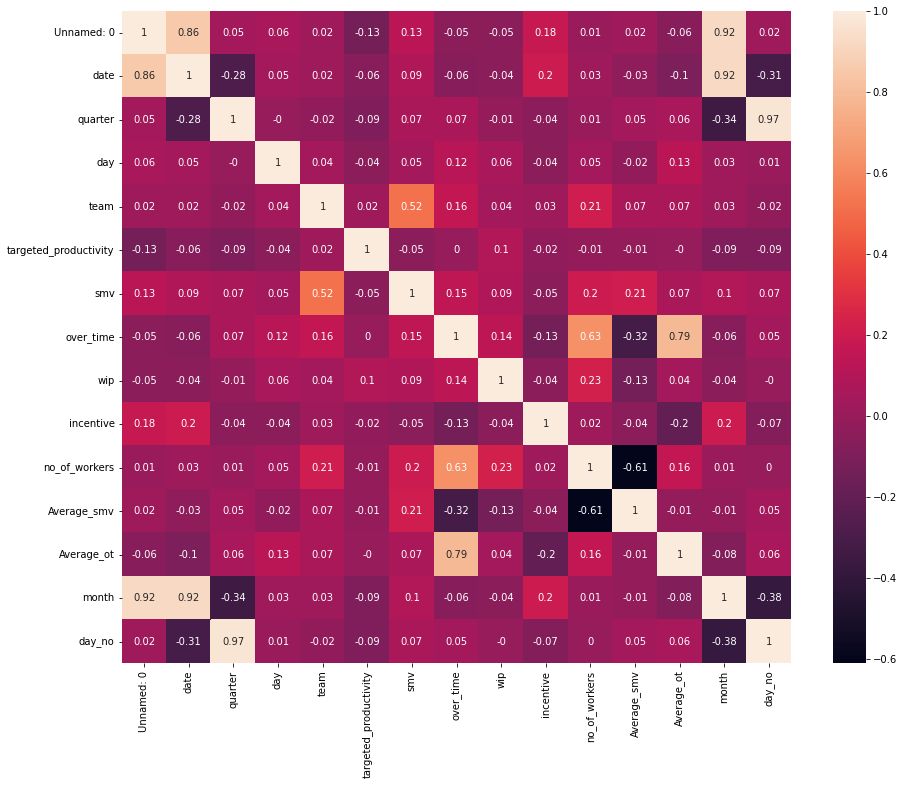

In [48]:
matrix = new_finishing_data_map.corr().round(2)
plt.figure(figsize=(15,12))
sns.heatmap(matrix, annot=True)
plt.savefig('raw data heatmap.png') 
plt.show()

In [25]:
finishing_features = new_finishing_data.iloc[:,1:17]
finishing_label = new_finishing_data.iloc[:,17]


In [26]:
finishing_features

,quarter,day,team,targeted_productivity,smv,over_time,wip,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,Average_smv,Average_ot,month,day_no
1,0,5,0.827803,0.75,3.94,960,1248.449707,0,0.0,0,0,8.0,49.250000,2.0,1,1
6,0,5,0.780130,0.75,3.94,960,1130.559570,0,0.0,0,0,8.0,49.250000,2.0,1,1
13,0,5,0.723417,0.65,3.94,960,1060.458618,0,0.0,0,0,8.0,49.250000,2.0,1,1
14,0,5,0.692657,0.75,2.90,960,1049.529053,0,0.0,0,0,8.0,36.250000,2.0,1,1
15,0,5,0.820643,0.75,3.94,2160,1228.368652,0,0.0,0,0,18.0,21.888889,2.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,1,4,0.723417,0.75,2.90,960,1003.802917,0,0.0,0,0,8.0,36.250000,2.0,3,11
1193,1,4,0.692657,0.70,3.90,960,1060.296143,0,0.0,0,0,8.0,48.750000,2.0,3,11
1194,1,4,0.685844,0.65,3.90,960,1076.577393,0,0.0,0,0,8.0,48.750000,2.0,3,11
1195,1,4,0.724527,0.75,2.90,1800,632.381226,0,0.0,0,0,15.0,19.333333,2.0,3,11


In [27]:
finishing_label

1       0.886500
6       0.755167
13      0.705917
14      0.676667
15      0.593056
          ...   
1192    0.628333
1193    0.625625
1194    0.625625
1195    0.505889
1196    0.394722
Name: actual_productivity, Length: 506, dtype: float64

In [28]:
standardizer = StandardScaler()
standardizer.fit(finishing_features)
finishing_features = standardizer.transform(finishing_features)

In [29]:
# Now we have the enough data, so the train_test_split size can be set to train:test = 8:2
SEED = 1
x_train, x_test, y_train, y_test = train_test_split(finishing_features, finishing_label, test_size=0.1, random_state=SEED)

In [30]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
mae_list=[]

In [60]:
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
for i in range(301,330,1):
    model_TR = TR(verbose=0,seed=i)
    model_TR.fit(X_train=x_train, y_train=y_train, eval_set=[(x_test, y_test)], patience=600, max_epochs=3000, eval_metric=['mae'])
    predictions = model_TR.predict(x_test)
    mae_score = mae(predictions, y_test)
    mae_list.append(mae_score)


Early stopping occurred at epoch 1337 with best_epoch = 737 and best_val_0_mae = 0.09566
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 695 with best_epoch = 95 and best_val_0_mae = 0.11783
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 1186 with best_epoch = 586 and best_val_0_mae = 0.08954
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 858 with best_epoch = 258 and best_val_0_mae = 0.10101
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 984 with best_epoch = 384 and best_val_0_mae = 0.10312
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 1449 with best_epoch = 849 and best_val_0_mae = 0.09374
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 847 with best_epoch = 247 and best_val_0_mae = 0.09878
Best weights from best epoch are automatically used!

Ear

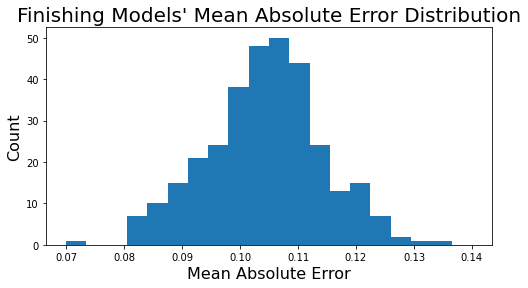

In [61]:
plt.figure(figsize=(8,4))
plt.title("Finishing Models' Mean Absolute Error Distribution", fontsize=20)
plt.xlabel('Mean Absolute Error', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.hist(mae_list, bins=20, range=(0.07,0.14))
plt.show() 

In [63]:
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
model_TR = TR(verbose=0,seed=315)
model_TR.fit(X_train=x_train, y_train=y_train, eval_set=[(x_test, y_test)], patience=600, max_epochs=3000, eval_metric=['mae'])


Early stopping occurred at epoch 1456 with best_epoch = 856 and best_val_0_mae = 0.08165
Best weights from best epoch are automatically used!


In [65]:
# Comparison between actual labels and predicted labels 
predictions = model_TR.predict(x_test).flatten() 
y_test = y_test.flatten()
Comparison = pd.DataFrame({"Actual_labels": y_test, "Predicted labels": predictions})
print(Comparison.to_string()) 

    Actual_labels  Predicted labels
0        0.664875          0.735554
1        0.919125          0.793241
2        0.827187          0.880170
3        0.858144          0.814542
4        0.783750          0.789737
5        0.852794          0.852825
6        0.853667          0.872361
7        0.763375          0.731038
8        0.856950          0.893139
9        0.817424          0.666976
10       0.477292          0.415319
11       0.734646          0.793839
12       0.860653          0.875533
13       0.911590          0.896673
14       0.902917          0.780691
15       0.376597          0.444636
16       0.811389          0.827904
17       0.971867          0.957376
18       0.803542          0.720675
19       0.728303          0.837090
20       0.725625          0.446759
21       1.033570          0.904744
22       0.796208          0.839994
23       0.604167          0.676286
24       0.930340          0.855751
25       0.342361          0.604928
26       0.664583          0

In [66]:
# code copied and modified from https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot/63560689#63560689

def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.
    
    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}
    
    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    
    """
    if ax is None:
        ax = plt.gca()
    
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, alpha=0.3, color='blue', edgecolor="")

    return ax


def plot_ci_bootstrap(xs, ys, resid, nboot=500, ax=None):
    """Return an axes of confidence bands using a bootstrap approach.

    Notes
    -----
    The bootstrap approach iteratively resampling residuals.
    It plots `nboot` number of straight lines and outlines the shape of a band.
    The density of overlapping lines indicates improved confidence.

    Returns
    -------
    ax : axes
        - Cluster of lines
        - Upper and Lower bounds (high and low) (optional)  Note: sensitive to outliers

    References
    ----------
    .. [1] J. Stults. "Visualizing Confidence Intervals", Various Consequences.
       http://www.variousconsequences.com/2010/02/visualizing-confidence-intervals.html

    """ 
    if ax is None:
        ax = plt.gca()

    bootindex = sp.random.randint

    for _ in range(nboot):
        resamp_resid = resid[bootindex(0, len(resid) - 1, len(resid))]
        # Make coeffs of for polys
        pc = sp.polyfit(xs, ys + resamp_resid, 1)                   
        # Plot bootstrap cluster
        ax.plot(xs, sp.polyval(pc, xs), "b-", linewidth=2, alpha=3.0 / float(nboot))

    return ax

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

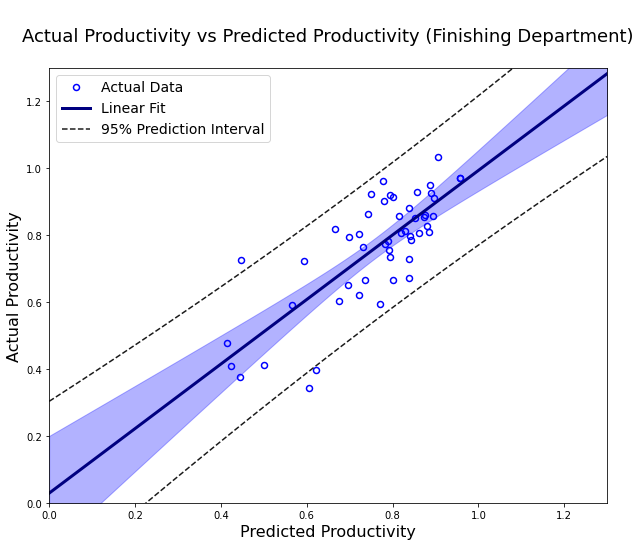

In [67]:
import scipy as sp
import scipy.stats as stats
# Computations ----------------------------------------------------------------    
# Modeling with Numpy
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

x = predictions
y = y_test
p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = len(predictions)                                       # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                                        # residuals; diff. actual data from predicted values
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 8))
plt.title("\n"+"Actual Productivity vs Predicted Productivity (Finishing Department)"+"\n", fontsize=18)
plt.ylim(ymin=0, ymax=1.3)
plt.xlim(xmin=0, xmax=1.3)
plt.xlabel('Predicted Productivity', fontsize=16)
plt.ylabel('Actual Productivity', fontsize=16)

# Data
ax.plot(
    x, y, "ro", color="#b9cfe7", markersize=6, 
    markeredgewidth=1.5, markeredgecolor="b", markerfacecolor="None")

# Fit
x2 = np.linspace(0, 1.3, 100)
y2 = equation(p, x2)
ax.plot(x2, y2, "-", color="navy", linewidth=3)  

# Confidence Interval (select one)
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
#plot_ci_bootstrap(x, y, resid, ax=ax)
   
# Prediction Interval
pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
ax.plot(x2, y2 - pi, "--", color="0.1")
ax.plot(x2, y2 + pi, "--", color="0.1")
ax.legend(["Actual Data","Linear Fit", "95% Prediction Interval"], fontsize=14)
plt.savefig('sewing model plot.png')
files.download('sewing model plot.png')  
plt.show()

In [68]:
# To Check the 95% prediction interval
# let x3 = prediction value you want to check
x3 = 0.8
y3 = equation(p, x3)
pi = t * s_err * np.sqrt(1 + 1/n + (x3 - np.mean(x))**2 / np.sum((x - np.mean(x))**2)) 
print("Prediction interval for prediction = {}: lower boundary = {:.2f}; expectation = {:.2f}; higher boundary = {:.2f}.".format(x3, y3-pi ,y3, y3+pi))

Prediction interval for prediction = 0.8: lower boundary = 0.58; expectation = 0.80; higher boundary = 1.02.


In [69]:
predictions = model_TR.predict(x_test).flatten()
y_test = y_test.flatten()
model_mae = mae(predictions, y_test)
correlation = np.corrcoef(predictions, y_test)
print("Model's mean absolute erro ={:.4f}".format(model_mae))
print("correlation = {:.4f}".format(correlation[0,1]))

Model's mean absolute erro =0.0816
correlation = 0.7808
